In [1]:
!nvidia-smi

Fri Oct  4 16:33:04 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.44       Driver Version: 512.44       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P5    22W /  N/A |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Setup

In [2]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime
%load_ext tensorboard

### Download the classifier

Selecting a <a href="https://arxiv.org/abs/1801.04381" class="external">MobileNetV23</a> pre-trained model [from TensorFlow Hub](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2) and wrap it as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer).

In [3]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"


classifier_model = mobilenet_v2 

In [4]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

## Simple transfer learning

### Dataset


In [5]:
import pathlib
data_dir = 'C:/Users/TRITON 500SE/Brain Tumor Detector/brain_tumor_dataset/' # This is changed according to dataset
data_dir = pathlib.Path(data_dir)

Loading the data into the model using the image data off disk with `tf.keras.utils.image_dataset_from_directory`, which will generate a `tf.data.Dataset`:

In [6]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 2065 files belonging to 2 classes.
Using 1652 files for training.


In [8]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 2065 files belonging to 2 classes.
Using 413 files for validation.


In [9]:
train_ds = train_dataset
val_ds = validation_dataset

See classes of the dataset:

In [10]:
class_names = np.array(train_ds.class_names)
print(class_names)

['no' 'yes']


Second, because TensorFlow Hub's convention for image models is to expect float inputs in the `[0, 1]` range, use the `tf.keras.layers.Rescaling` preprocessing layer to achieve this.

In [11]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [15]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor_model = mobilenet_v2

Creating the feature extractor by wrapping the pre-trained model as a Keras layer with [`hub.KerasLayer`](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer). Use the `trainable=False` argument to freeze the variables, so that the training only modifies the new classifier layer:

In [16]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

The feature extractor returns a 1280-long vector for each image (the image batch size remains at 32 for this project)

In [17]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


### Attach a classification head

To complete the model, wrap the feature extractor layer in a `tf.keras.Sequential` model and add a fully-connected layer for classification:

In [18]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [19]:
predictions = model(image_batch)

In [20]:
predictions.shape

TensorShape([32, 2])

### Training the model

Use `Model.compile` to configure the training process and add a `tf.keras.callbacks.TensorBoard` callback to create and store logs:

In [21]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

Now use the `Model.fit` method to train the model.

To keep this example short, you'll be training for just 10 epochs. To visualize the training progress in TensorBoard later, create and store logs an a [TensorBoard callback](https://www.tensorflow.org/tensorboard/get_started#using_tensorboard_with_keras_modelfit).

In [22]:
import time
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

# Your existing code
NUM_EPOCHS = 10
tensorboard_callback = TensorBoard(log_dir="logs")

# Adding EarlyStopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# Start time
start_time = time.time()

# Train the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=[tensorboard_callback, early_stopping_callback])

# End time
end_time = time.time()


Epoch 1/10
52/52 [==============================] - 29s 475ms/step - loss: 0.4479 - acc: 0.7881 - val_loss: 0.3104 - val_acc: 0.8814
Epoch 2/10
52/52 [==============================] - 23s 450ms/step - loss: 0.2356 - acc: 0.9146 - val_loss: 0.2415 - val_acc: 0.9128
Epoch 3/10
52/52 [==============================] - 35s 684ms/step - loss: 0.1783 - acc: 0.9389 - val_loss: 0.2119 - val_acc: 0.9225
Epoch 4/10
52/52 [==============================] - 23s 453ms/step - loss: 0.1472 - acc: 0.9528 - val_loss: 0.1921 - val_acc: 0.9298
Epoch 5/10
52/52 [==============================] - 42s 825ms/step - loss: 0.1265 - acc: 0.9600 - val_loss: 0.1769 - val_acc: 0.9395
Epoch 6/10
52/52 [==============================] - 24s 473ms/step - loss: 0.1113 - acc: 0.9661 - val_loss: 0.1643 - val_acc: 0.9443
Epoch 7/10
52/52 [==============================] - 25s 477ms/step - loss: 0.0995 - acc: 0.9734 - val_loss: 0.1533 - val_acc: 0.9467
Epoch 8/10
52/52 [==============================] - 24s 460ms/step - 

In [23]:

# Calculate and print training time
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")


Total training time: 339.68 seconds


Start the TensorBoard to view how the metrics change with each epoch and to track other scalar values:

In [24]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 36616), started 1 day, 13:26:31 ago. (Use '!kill 36616' to kill it.)

<!-- <img class="tfo-display-only-on-site" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/images/tensorboard_transfer_learning_with_hub.png?raw=1"/> -->

### Checking the predictions

Obtaining the ordered list of class names from the model predictions:

In [25]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 1s 1s/step
['yes' 'yes' 'yes' 'no' 'yes' 'yes' 'no' 'no' 'yes' 'yes' 'no' 'yes' 'no'
 'no' 'no' 'no' 'no' 'yes' 'yes' 'no' 'no' 'no' 'yes' 'no' 'yes' 'yes'
 'no' 'yes' 'yes' 'no' 'yes' 'yes']


Plot the model predictions:

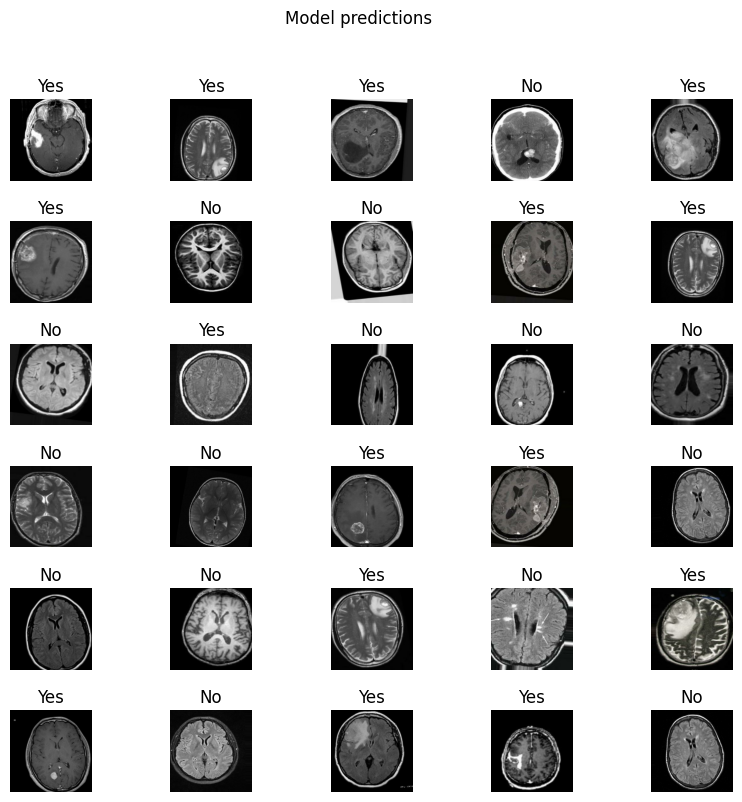

In [26]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

### Export and reload the model


In [27]:
t = time.time()

export_path = "C:/Users/TRITON 500SE/Brain Tumor Detector/models/{}".format(int(t))
model.save(export_path)

INFO:tensorflow:Assets written to: C:/Users/TRITON 500SE/Brain Tumor Detector/models/1728056457\assets


INFO:tensorflow:Assets written to: C:/Users/TRITON 500SE/Brain Tumor Detector/models/1728056457\assets


Confirming that the Saved Model can be reloaded and that the model is able to output the same results:

In [28]:
reloaded = tf.keras.models.load_model(export_path)

In [29]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

1/1 [==============================] - 3s 3s/step


In [30]:
abs(reloaded_result_batch - result_batch).max()

0.0

In [31]:
reloaded_predicted_id = tf.math.argmax(reloaded_result_batch, axis=-1)
reloaded_predicted_label_batch = class_names[reloaded_predicted_id]
print(reloaded_predicted_label_batch)

['yes' 'yes' 'yes' 'no' 'yes' 'yes' 'no' 'no' 'yes' 'yes' 'no' 'yes' 'no'
 'no' 'no' 'no' 'no' 'yes' 'yes' 'no' 'no' 'no' 'yes' 'no' 'yes' 'yes'
 'no' 'yes' 'yes' 'no' 'yes' 'yes']


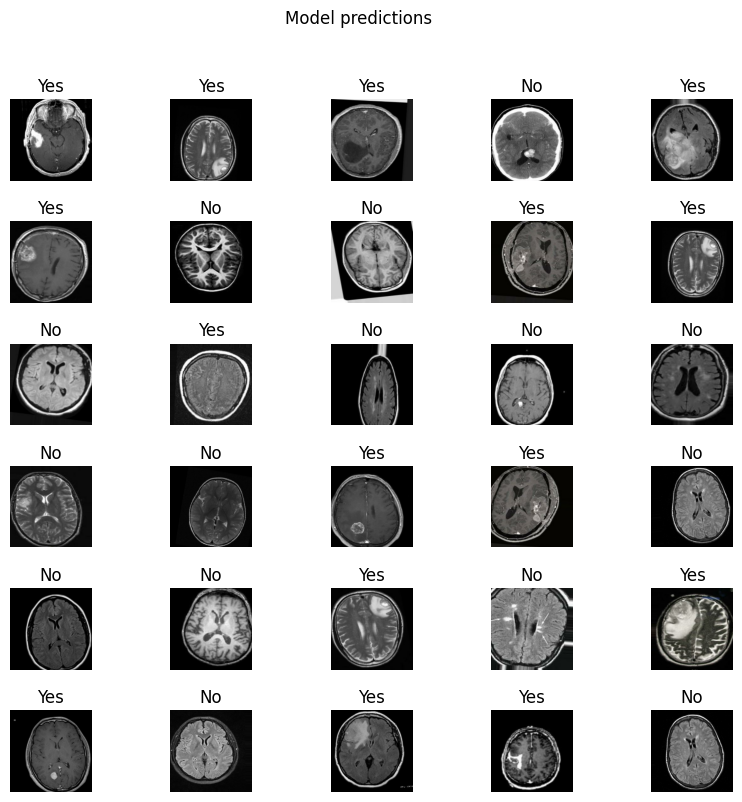

In [32]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(reloaded_predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

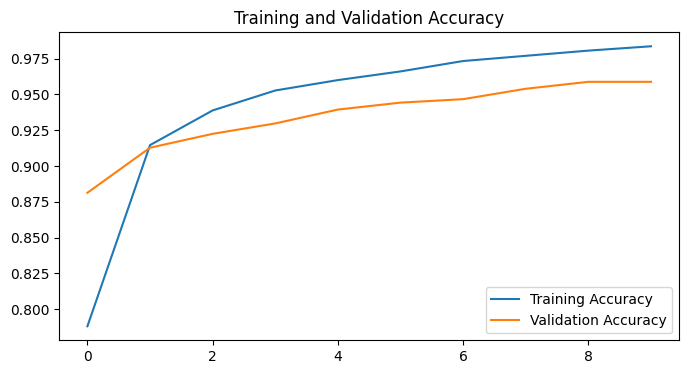

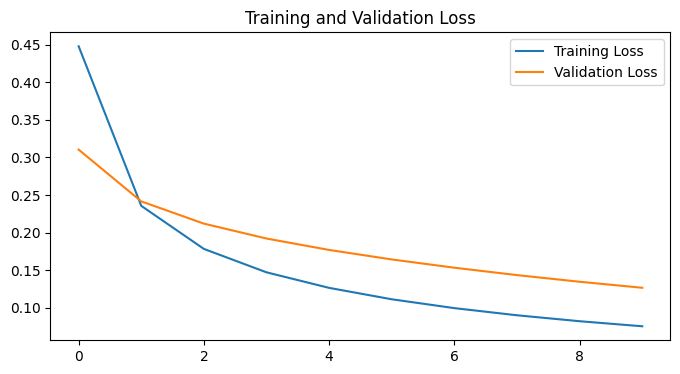

In [33]:
import matplotlib.pyplot as plt

# Extract training and validation accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plotting Training & Validation Accuracy
plt.figure(figsize=(8, 4))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

# Plotting Training & Validation Loss
plt.figure(figsize=(8, 4))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [34]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [36]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Is TensorFlow built with CUDA:", tf.test.is_built_with_cuda())


TensorFlow version: 2.13.0
Num GPUs Available: 0
Is TensorFlow built with CUDA: False


In [37]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Is TensorFlow built with CUDA:", tf.test.is_built_with_cuda())


TensorFlow version: 2.13.0
Num GPUs Available: 0
Is TensorFlow built with CUDA: False
